### **Ajuste de modelos** 

* A partir de las transformaciones propuestas ajustar distintos modelos (S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad del modelo.
* **Ajustar y predecir usando redes neuronales LSTM.**
* Comparar con predicciones usando SARIMA y extraer conclusiones.**
* Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y comparar con las componentes cíclica y estacional usando la descomposición.

In [1]:
from imports import *

In [2]:
#%matplotlib widget

In [ ]:
LOOKBACK = 28
HIDDEN_SIZE = 25
INPUT_SIZE = 1
LR = 0.0003
NUM_LAYERS = 1
N_EPOCHS = 300

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [8]:
from utils import series_to_array
bikes_data = process_file()
timeseries = series_to_array(bikes_data)

In [9]:
len(timeseries)

488

In [10]:
train_size = int(len(timeseries) * 0.85)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [11]:
lookback=LOOKBACK

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

from utils import scale_data

X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

X_train torch.Size([386, 28, 1]) y_train torch.Size([386, 28, 1])
X_test torch.Size([46, 28, 1]) y_test torch.Size([46, 28, 1])


#### Defining LSTM Model and hyperparameters

In [12]:
from model import LSTMModel

model = LSTMModel(input_size=INPUT_SIZE, num_layers=NUM_LAYERS, hidden_size=HIDDEN_SIZE)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2826


#### Training

In [14]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, 
                                     n_epochs=N_EPOCHS, print_interval=50, seed=42)

In [15]:
X_train.shape

torch.Size([386, 28, 1])

#### Evaluating on train and test

In [20]:
from model import evaluate_model_last_prediction
train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(model, X_train, 
                                                                                                       y_train, X_test, y_test, scaler_y, loss_fn)

In [21]:
test_rmse

[499.15376826685383]

In [22]:
# creo un array concatenando las predicciones
train_preds = np.concatenate([tensor.flatten() for tensor in train_preds])
test_preds = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_preds), len(test_preds)

(386, 46)

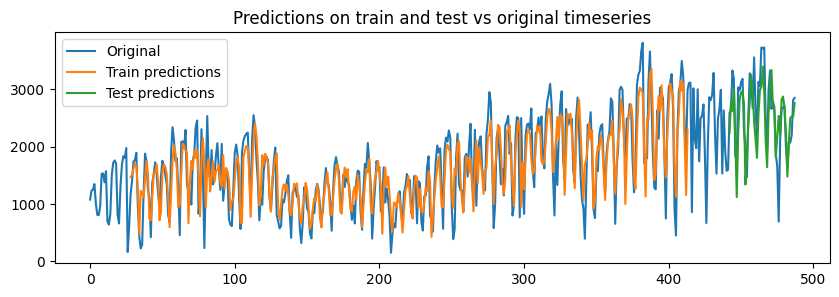

In [23]:
plt.figure(figsize=(10,3))
plt.plot(timeseries, label="Original")
plt.plot(range(lookback, lookback + len(train_preds)), train_preds, label="Train predictions")
plt.plot(range(2*lookback + len(train_preds), 2*lookback + len(train_preds) + len(test_preds)), test_preds, label="Test predictions")
plt.title("Predictions on train and test vs original timeseries")
plt.legend()

In [24]:
print("test:", test_loss, "train:", train_loss)

test: [0.02589658461511135] train: [0.013515815138816833]


#### Plotting correlation results

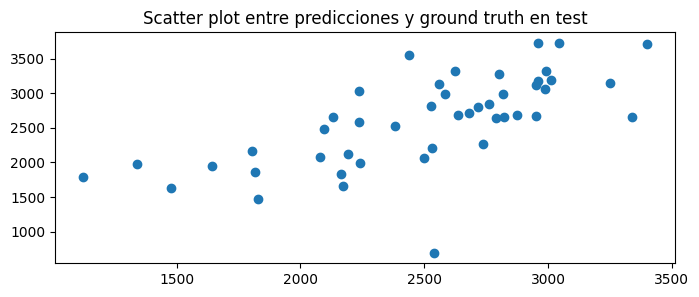

In [27]:
plt.figure(figsize=(8,3))
plt.scatter(test_preds, test[lookback:])
plt.title("Scatter plot entre predicciones y ground truth en test")
plt.show()

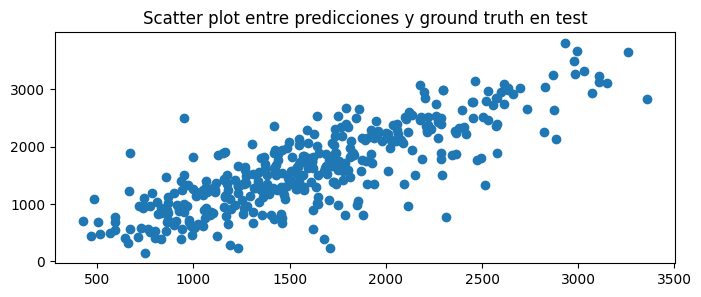

In [28]:
plt.figure(figsize=(8,3))
plt.scatter(train_preds, train[lookback:])
plt.title("Scatter plot entre predicciones y ground truth en test")
plt.show()